# Generate Data Points

The problem is that $\nabla^{2} T(x,y) = 0$ in $(x,y) \in [0,1] \times [0,1]$ with boudnary condition

$$
\begin{cases}
    T(0,y)=150\\
    T(1,y)=0\\
    T(x,1)=50\\
    T(x,0)=100
\end{cases}
$$.

So, define the grid size $N$ and set data grids $(N+1) \times (N+1)$ in given $(0,1) \times (0,1)$ grid. So boundary points at $i=0$ and $i=N$ and updating points is at $i=1 - (N-1)$.


In [9]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
tolerance = 1e-6
max_iterations = 50000

class DataGrid:
    def __init__(self, N):
        self.N = N
        self.h = 1/(N+1)
        self.x = np.linspace(0, 1, N+1)
        self.y = np.linspace(0, 1, N+1)
        self.T = np.zeros((N+1, N+1))
        # (j,i) = (x,y)
        self.T[:, 0] = 150 # T(0,y)=150
        self.T[:, N] = 0 # T(1,y)=0
        self.T[0, :] = 50 # T(x,1)=50
        self.T[N, :] = 100 # T(x,0)=100
    
    def show(self):
        X,Y = np.meshgrid(self.x, self.y)
        x_left, y_left = np.meshgrid(self.x[0], self.y)
        x_left = x_left.flatten()
        y_left = y_left.flatten()
        x_right, y_right = np.meshgrid(self.x[self.N], self.y)
        x_right = x_right.flatten()
        y_right = y_right.flatten()
        x_top, y_top = np.meshgrid(self.x, self.y[0])
        x_top = x_top.flatten()
        y_top = y_top.flatten()
        x_bottom, y_bottom = np.meshgrid(self.x, self.y[self.N])
        x_bottom = x_bottom.flatten()
        y_bottom = y_bottom.flatten()
        bc_points_x = np.concatenate([x_left, x_right, x_top, x_bottom], axis=0)
        bc_points_y = np.concatenate([y_left, y_right, y_top, y_bottom], axis=0)

        bc_left = self.T[:, 0]
        bc_right = self.T[:, self.N]
        bc_top = self.T[0, :]
        bc_bottom = self.T[self.N, :]
        bc_values = np.concatenate([bc_left, bc_right, bc_top, bc_bottom], axis=0)

        plt.figure(figsize=(10, 10))
        plt.scatter(X, Y, c='red', marker='.')
        plt.scatter(bc_points_x, bc_points_y, c=bc_values, marker='*', vmin=0, vmax=150)
        plt.colorbar(label='Temperature')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Boundary Points')
        plt.show()

    def update(self, T_new):
        self.T = T_new

    def get_T(self, i, j):
        return self.T[i, j]

    def get_xy(self, i, j):
        return self.x[i], self.y[j]

    def get_T_at_xy(self, x, y):
        i = np.argmin(np.abs(self.x - x))
        j = np.argmin(np.abs(self.y - y))
        return self.T[i, j]

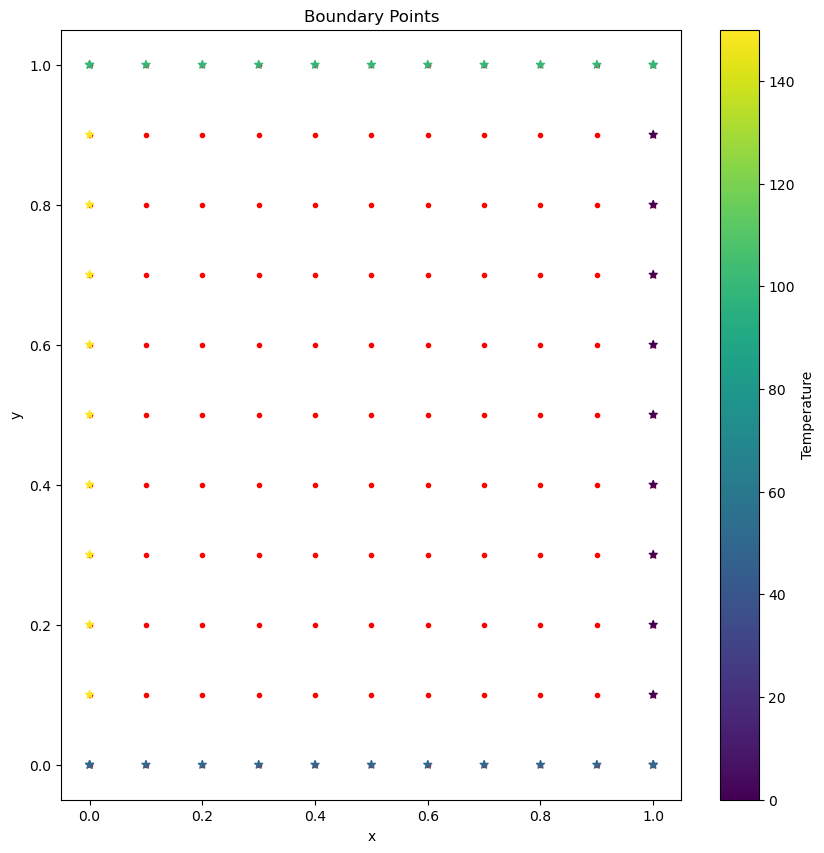

In [10]:
data_grid = DataGrid(10)
data_grid.show()

# Jacobi iteration (Relaxation Method)

$$
\varphi_{i,j}^{n+1} = \frac{1}{4} \left( \varphi_{i+1,j}^{n} + \varphi_{i-1,j}^{n} + \varphi_{i,j+1}^{n} + \varphi_{i,j-1}^{n} \right)
$$

In [11]:
import time
from tqdm import tqdm

class Jacobi:
    def __init__(self, data_grid, error_threshold=1e-6, max_iterations=1000):
        self.data_grid = data_grid
        self.data = data_grid.T
        self.N = data_grid.N
        self.argmax_error = 0
        self.threshold = error_threshold
        self.error_history = []
        self.running_time = 0
        self.max_iterations = max_iterations

    def update(self):
        self.data_new = self.data.copy()
        self.data_new[1:-1, 1:-1] = (self.data[1:-1, 1:-1] + self.data[1:-1, 2:] + self.data[2:, 1:-1] + self.data[1:-1, :-2]) / 4
        self.argmax_error = np.max(np.abs(self.data - self.data_new))
        self.error_history.append(self.argmax_error)
        self.data = self.data_new
        if self.argmax_error < self.threshold:
            return True
        return False
    
    def train(self):
        start_time = time.time()
        for i in tqdm(range(self.max_iterations)):
            if self.update():
                end_time = time.time()
                self.running_time = end_time - start_time
                break
        return self.data, self.running_time

    def show_distribution(self):
        plt.imshow(self.data, cmap='jet')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Temperature Distribution')
        plt.colorbar()
        plt.show()

    def show_error_history(self):
        plt.plot(self.error_history)
        plt.xlabel('Iteration (Finished at {})'.format(len(self.error_history)))
        plt.ylabel('Error')
        plt.title('Error History (Tolerance: {})'.format(self.threshold))
        plt.show()


In [14]:
model = Jacobi(DataGrid(N), tolerance, max_iterations)
solution, Run_time_Jacobi = model.train()
print(f"Running time: {Run_time_Jacobi} seconds")

 61%|██████    | 607/1000 [00:00<00:00, 6127.54it/s]

Running time: 0.1010749340057373 seconds


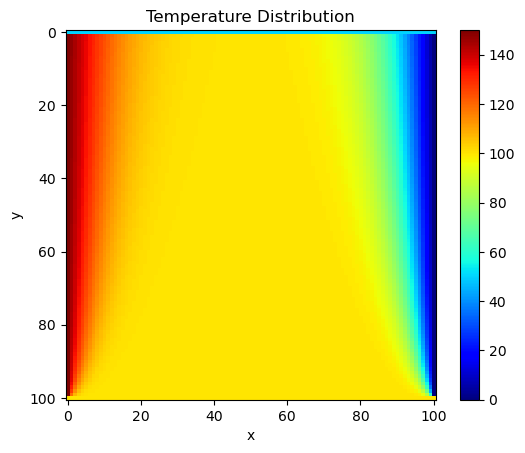

In [15]:
model.show_distribution()

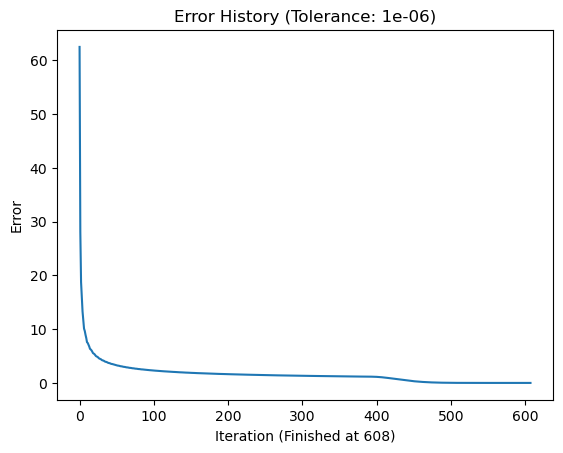

In [16]:
model.show_error_history()

# Gauss-Seidal method

$$
\varphi_{i,j}^{n+1} = \frac{1}{4} \left( \textcolor{red}{\varphi_{i-1,j}^{n+1}} + \varphi_{i+1,j}^{n} + \textcolor{red}{\varphi_{i,j-1}^{n+1}} + \varphi_{i,j+1}^{n} \right)
$$

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

class GaussSeidel:
    def __init__(self, data_grid, error_threshold=1e-6, max_iterations=1000):
        self.data_grid = data_grid
        self.data = data_grid.T
        self.N = data_grid.N
        self.argmax_error = 0
        self.threshold = error_threshold
        self.error_history = []
        self.running_time = 0
        self.max_iterations = max_iterations
        
    def update(self):
        data_prev = self.data.copy()
        for i in range(1, self.N-1):
            for j in range(1, self.N-1):
                self.data[i, j] = (self.data[i-1, j] + self.data[i+1, j] + self.data[i, j-1] + self.data[i, j+1]) / 4
        self.argmax_error = np.max(np.abs(self.data - data_prev))
        self.error_history.append(self.argmax_error)
        if self.argmax_error < self.threshold:
            return True
        return False
    
    def train(self):
        start_time = time.time()
        for i in tqdm(range(self.max_iterations)):
            if self.update():
                end_time = time.time()
                self.running_time = end_time - start_time
                break
        return self.data, self.running_time
    
    def show_distribution(self):
        plt.imshow(self.data, cmap='jet')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Temperature Distribution')
        plt.colorbar()
        plt.show()
    
    def show_error_history(self):
        plt.plot(self.error_history)
        plt.xlabel('Iteration (Finished at {})'.format(len(self.error_history)))
        plt.ylabel('Error')
        plt.title('Error History (Tolerance: {})'.format(self.threshold))
        plt.show()

In [25]:
model = GaussSeidel(DataGrid(N), tolerance, max_iterations)
solution, time_GaussSeidel = model.train()

100%|██████████| 10000/10000 [00:51<00:00, 194.15it/s]


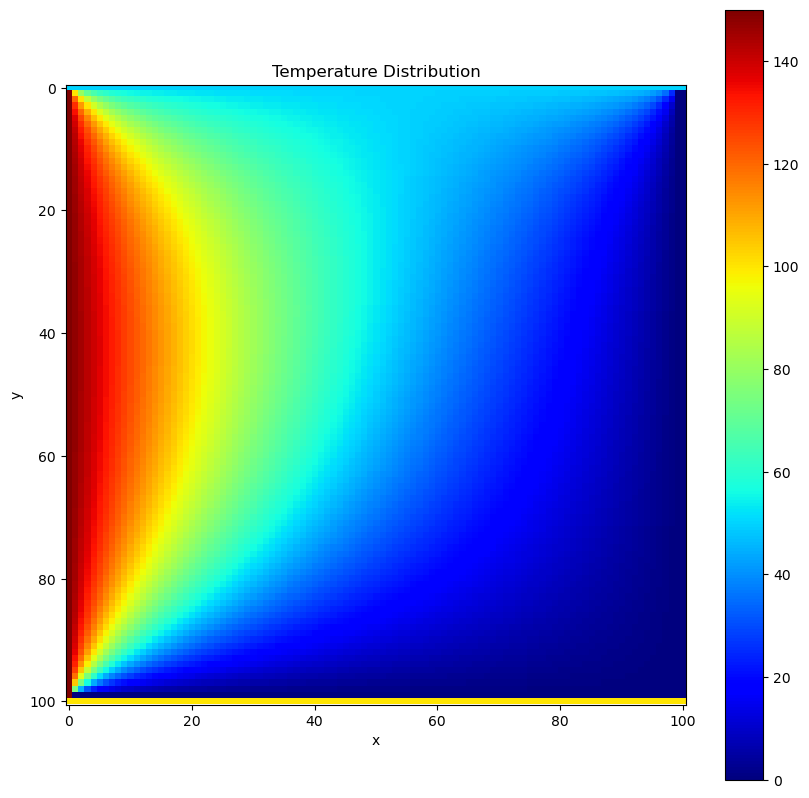

In [26]:
plt.figure(figsize=(10, 10))
model.show_distribution()

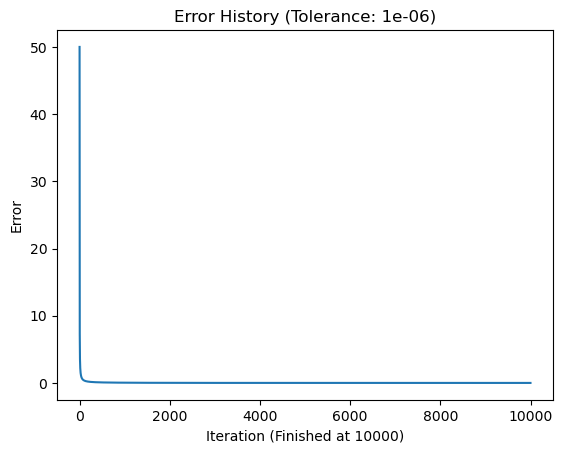

3.36974455450445e-06


In [27]:
model.show_error_history()
print(model.error_history[-1])